In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing required libraries
import requests
import csv
from itertools import permutations
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

## Principal Component Analysis:

In order to find out any Correlations between the features for the rebap energy price, we combine several data sets into ONE data frame and analyse it via Correlation Analysis. As input data sets we choose:
1. regelleistung_aggr_4h.csv
2. onlinehochrechnung_windoffshore_mw.csv
3. onlinehochrechnung_windonshore_mw.csv
4. onlinehochrechnung_solar_mw.csv
5. power_act_.csv
6. power_fc_.csv
7. EQ_epex_da_last_prognosis_count.csv
8. es_fc_solar_ts.csv
9. es_fc_total_load_ts.csv
10. es_fc_total_renewables_ts.csv
11. es_fc_wind_offshore_ts.csv
12. es_fc_wind_onshore_ts.csv
13. wind_speed_ts.csv (In data/data_processed folder, created from einspeisedaten_gen_wind_speed.csv)
14. imbalance_de_labeled.csv(in data/data_processed folder, remove "power_mw" column)

In [3]:
df_1 = pd.read_csv("data/PCA Data Sets/regelleistung_aggr_4h.csv")

In [4]:
df_1['timestamp']=df_1['timestamp'].astype('datetime64')

In [5]:
df_2 = pd.read_csv("data/PCA Data Sets/onlinehochrechnung_windoffshore_mw.csv", delimiter= "///")

In [6]:
df_2['dt_start_utc']=df_2['dt_start_utc'].astype('datetime64')

In [7]:
df_3 = pd.read_csv("data/PCA Data Sets/onlinehochrechnung_windonshore_mw.csv")

In [8]:
df_3.columns = ["dt_start_utc", "fiftyherz", "tennet", "amprion", "transnetbw", "nrv"]

In [9]:
df_3['dt_start_utc']=df_3['dt_start_utc'].astype('datetime64')

In [10]:
df_4 = pd.read_csv("data/PCA Data Sets/onlinehochrechnung_solar_mw.csv")

In [11]:
df_4['dt_start_utc']=df_4['dt_start_utc'].astype('datetime64')

In [12]:
df_5 = pd.read_csv("data/PCA Data Sets/power_act_.csv")

In [13]:
df_5['dt_start_utc']=df_5['dt_start_utc'].astype('datetime64')

In [14]:
df_6 = pd.read_csv("data/PCA Data Sets/power_fc_.csv")

In [15]:
df_6['dt_start_utc']=df_6['dt_start_utc'].astype('datetime64')

In [16]:
df_7 = pd.read_csv("data/PCA Data Sets/EQ_epex_da_last_prognosis_count.csv")

In [17]:
df_7['timestamp']=df_7['timestamp'].astype('datetime64')

In [18]:
df_8 = pd.read_csv("data/PCA Data Sets/es_fc_solar_ts.csv")

In [19]:
df_8['dt_start_utc']=df_8['dt_start_utc'].astype('datetime64')

In [20]:
df_9 = pd.read_csv("data/PCA Data Sets/es_fc_total_load_ts.csv")

In [21]:
df_9['dt_start_utc']=df_9['dt_start_utc'].astype('datetime64')

In [22]:
df_10 = pd.read_csv("data/PCA Data Sets/es_fc_total_renewables_ts.csv")

In [23]:
df_10['dt_start_utc']=df_10['dt_start_utc'].astype('datetime64')

In [24]:
df_11 = pd.read_csv("data/PCA Data Sets/es_fc_wind_offshore_ts.csv")

In [25]:
df_11['dt_start_utc']=df_11['dt_start_utc'].astype('datetime64')

In [26]:
df_12 = pd.read_csv("data/PCA Data Sets/es_fc_wind_onshore_ts.csv")

In [27]:
df_12['dt_start_utc']=df_12['dt_start_utc'].astype('datetime64')

In [28]:
df_13 = pd.read_csv("data/PCA Data Sets/wind_speed_ts.csv")

In [29]:
df_13['dt_start_utc']=df_13['dt_start_utc'].astype('datetime64')

In [30]:
df_14 = pd.read_csv("data/PCA Data Sets/imbalance_de_labeled.csv")

In [31]:
df_14['dt_start_utc']=df_14['dt_start_utc'].astype('datetime64')

In [32]:
df_14 = df_14.drop(["power_mw"], axis=1)

We know there are meaningful correlation between the features in df_13 and the rebap imbalance price, therefore we create a combination dataframe out of the two of them:

In [33]:
from apymb import *
df_pca = align(df_13, df_14)

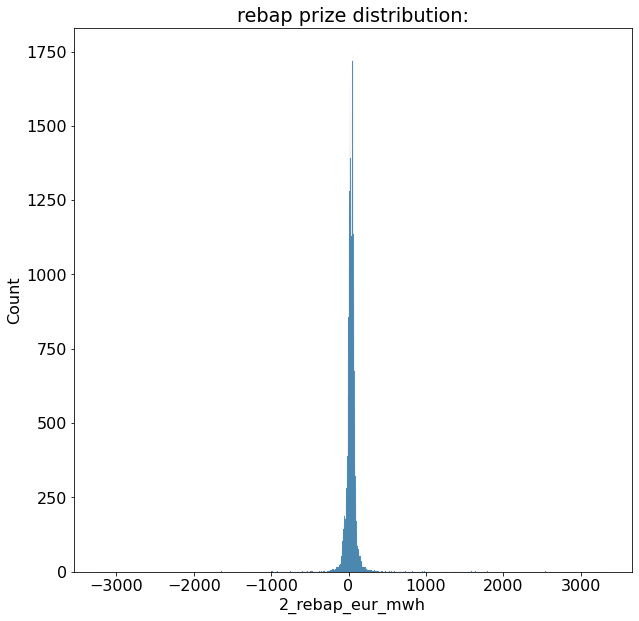

In [34]:
plt.figure(figsize=(10,10));
plt.rcParams.update({'font.size':16})
plt.title('rebap prize distribution:')
sns.histplot(data=df_pca, x="2_rebap_eur_mwh")
plt.show()

In [35]:
df_pca.to_csv("data/PCA Data Sets/PCA_combined_Data.csv")

In [36]:
df_pca.shape

(53610, 109)

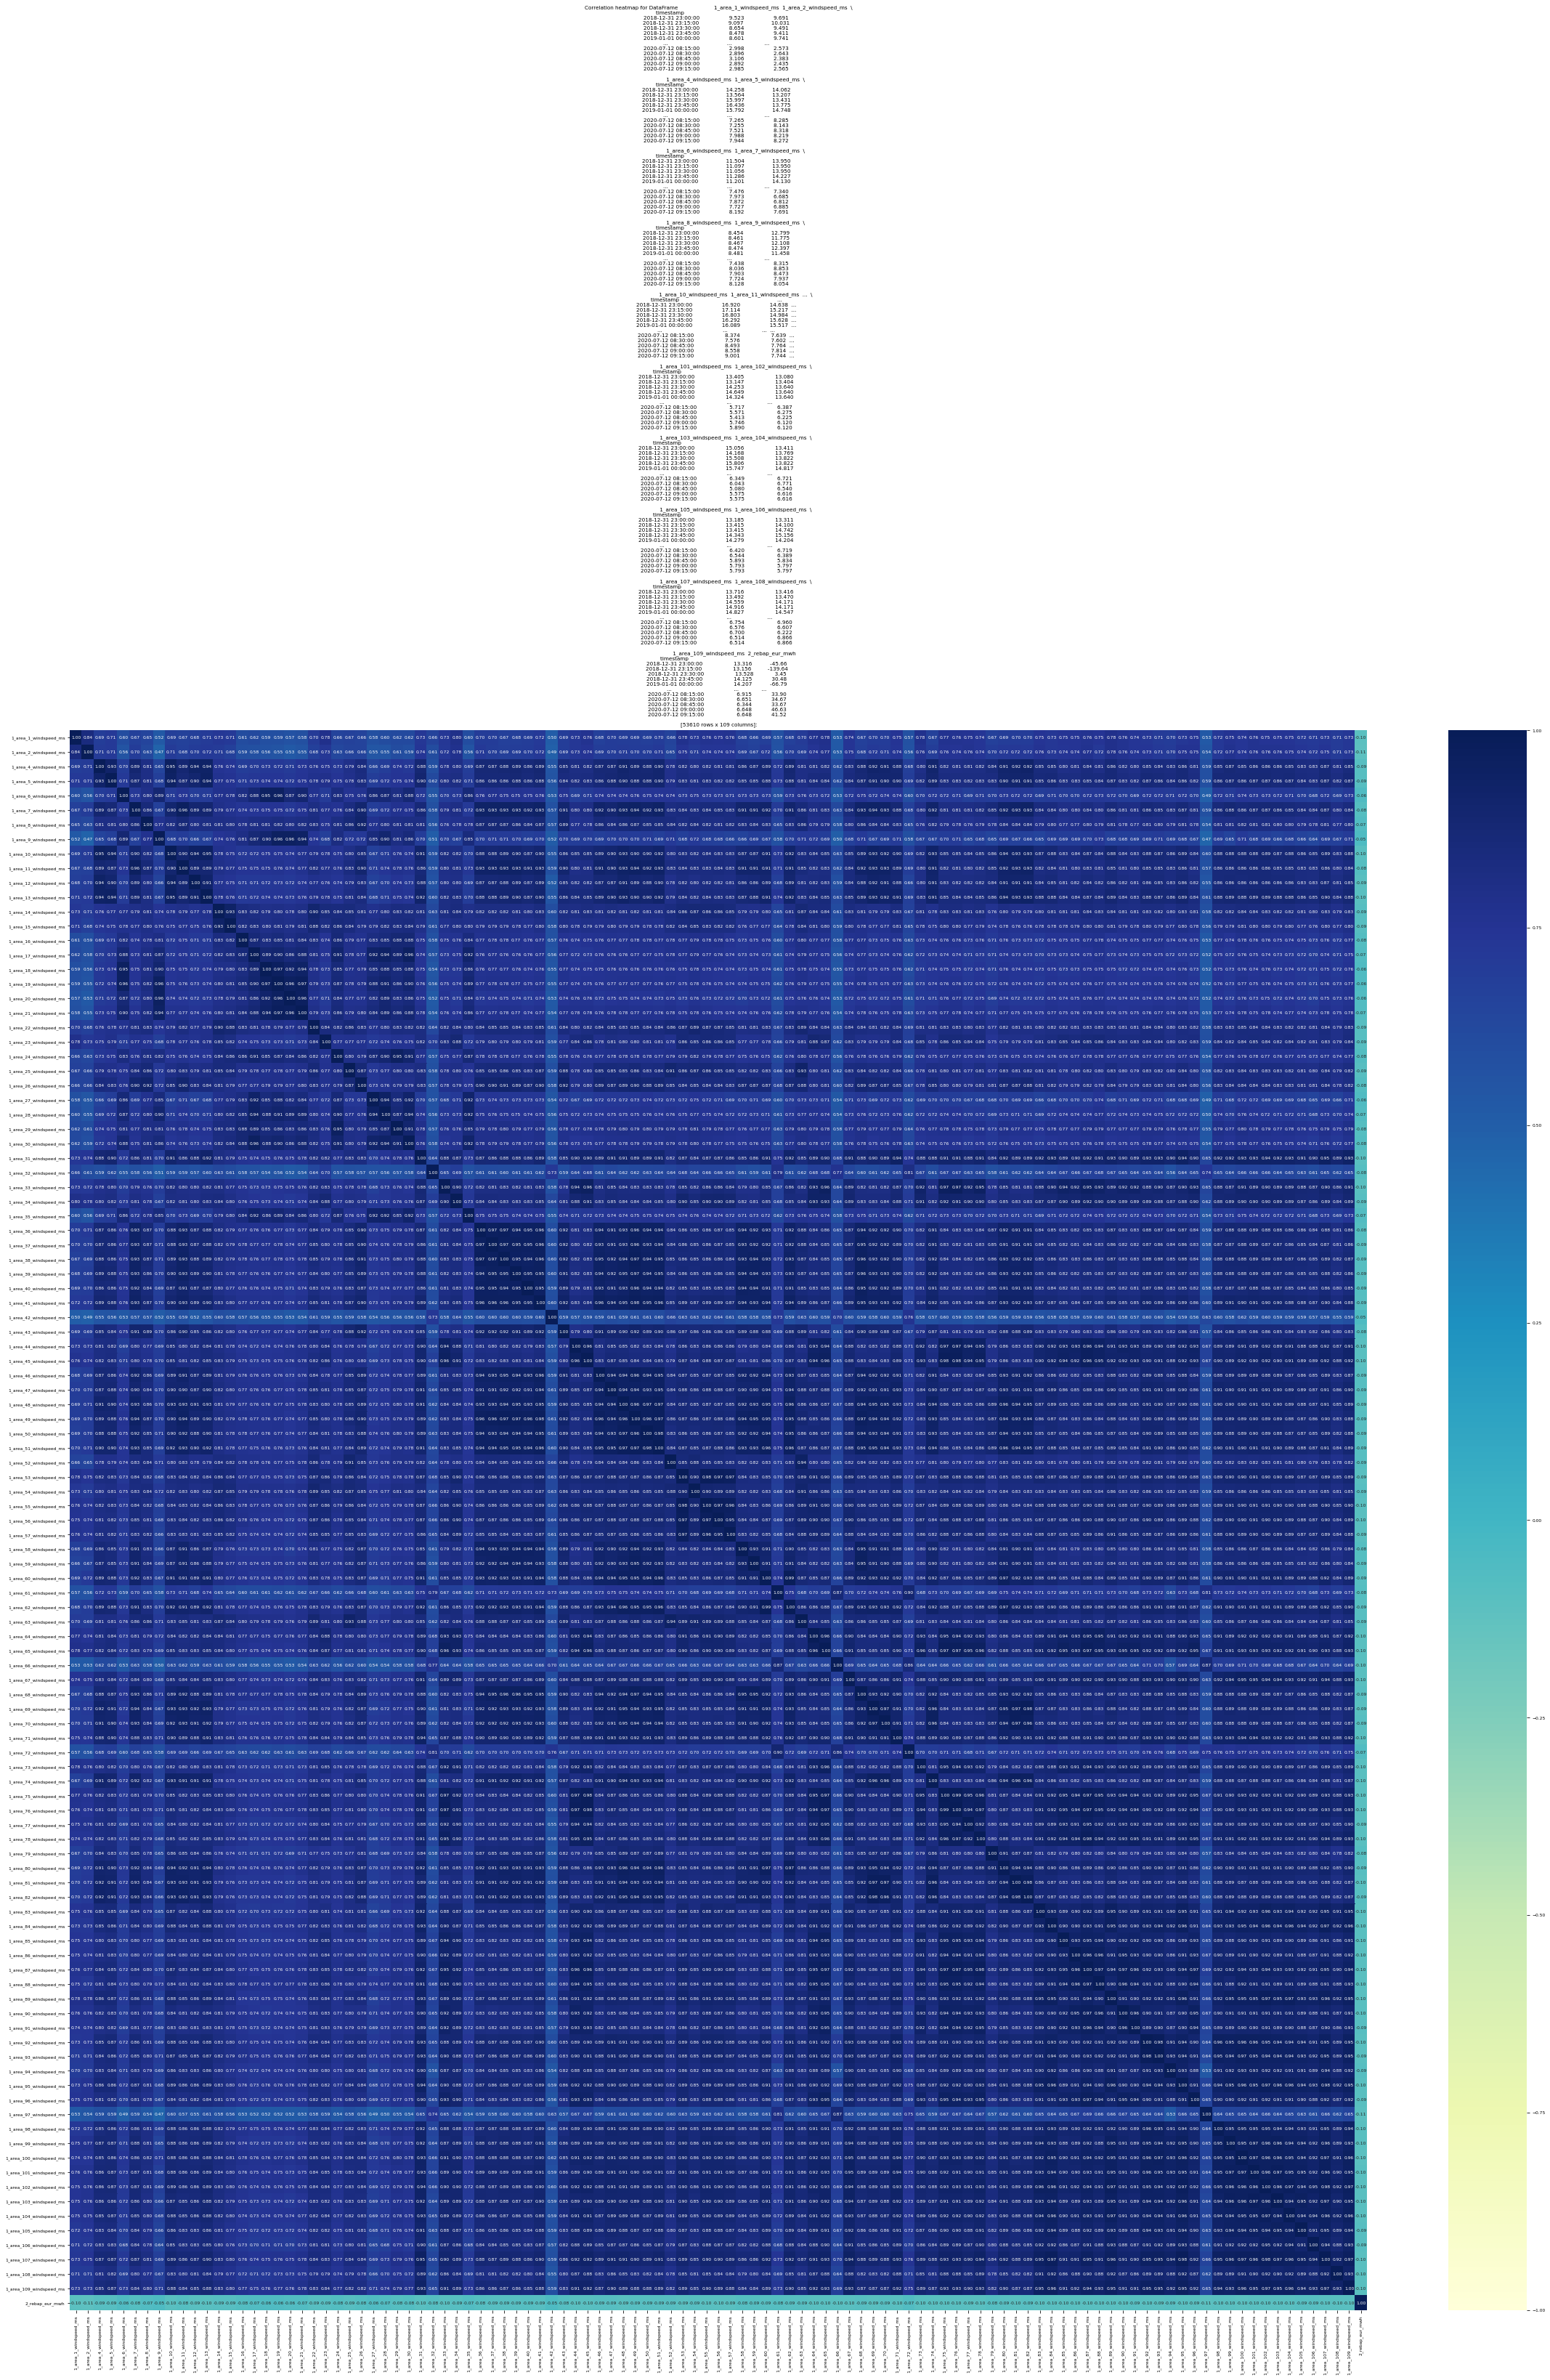

In [37]:
import seaborn as sns

def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm
    # Correlation heatmap for reduced DataFrame df_ml:
    plt.figure(figsize=(40,40));
    plt.rcParams.update({'font.size':6})
    plt.title(f'Correlation heatmap for DataFrame {df}:')
    correlations = df.iloc[:, :].corr()
    mask = np.triu(correlations)
    sns.heatmap(correlations ,fmt='.2f', vmax=1, vmin=-1, annot=True, mask=None, cmap="YlGnBu");
    # plt.savefig('pictures/Correlation_Heatmap2.png', transparent=True)

correlation_matrix(df_pca)

### Filter out those rebap prizes that are not within 3 Standard deviations of the mean:

Now we will get rid of those outliers outside the +/- 3 Standard Deviation range with the following code line:

In [38]:
y_median = df_pca['2_rebap_eur_mwh'][:-4].median()
y_median

33.81

In [39]:
std_dev = 3*df_pca['2_rebap_eur_mwh'].std()
df_pca = df_pca[np.abs(df_pca['2_rebap_eur_mwh'] - df_pca['2_rebap_eur_mwh'].mean()) <= std_dev]

In [338]:
"""
len_trainset = int(0.8 * len(df_pca['2_rebap_eur_mwh']))

y_median_train = df_pca['2_rebap_eur_mwh'][:len_trainset].median()
y_median_test = df_pca['2_rebap_eur_mwh'][len_trainset:].median()
print(y_median_train, y_median_test)
"""

"\nlen_trainset = int(0.8 * len(df_pca['2_rebap_eur_mwh']))\n\ny_median_train = df_pca['2_rebap_eur_mwh'][:len_trainset].median()\ny_median_test = df_pca['2_rebap_eur_mwh'][len_trainset:].median()\nprint(y_median_train, y_median_test)\n"

In [40]:
df_pca.describe()

,1_area_1_windspeed_ms,1_area_2_windspeed_ms,1_area_4_windspeed_ms,1_area_5_windspeed_ms,1_area_6_windspeed_ms,1_area_7_windspeed_ms,1_area_8_windspeed_ms,1_area_9_windspeed_ms,1_area_10_windspeed_ms,1_area_11_windspeed_ms,...,1_area_101_windspeed_ms,1_area_102_windspeed_ms,1_area_103_windspeed_ms,1_area_104_windspeed_ms,1_area_105_windspeed_ms,1_area_106_windspeed_ms,1_area_107_windspeed_ms,1_area_108_windspeed_ms,1_area_109_windspeed_ms,2_rebap_eur_mwh
count,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,...,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000
mean,6.553995,6.452053,8.081869,8.755412,7.331141,6.893471,7.125824,7.745754,8.815519,7.369862,...,6.941514,6.976944,7.374455,7.197527,6.924992,7.039588,7.140904,7.648715,7.249270,32.063320
std,2.696233,2.591440,3.606232,3.637916,3.099977,3.156570,2.920353,3.348886,4.059416,3.316472,...,3.409851,3.327733,3.643207,3.354086,3.435083,3.456958,3.458647,3.528072,3.493424,46.385289
min,0.190000,0.848000,0.335000,0.183000,0.026000,0.248000,0.062000,0.036000,0.169000,0.108000,...,0.221000,0.109000,0.056000,0.037000,0.221000,0.079000,0.054000,0.000000,0.019000,-196.170000
25%,4.762000,4.666000,5.482000,6.204000,5.141000,4.793000,5.163000,5.425000,5.917000,5.101000,...,4.569000,4.579000,4.785000,4.785000,4.720000,4.474000,4.664000,5.056000,4.711000,9.250000
50%,6.352000,6.195000,7.580000,8.592000,7.133000,6.441000,6.934000,7.508000,8.327000,6.985000,...,6.335000,6.439000,6.639000,6.755000,6.325000,6.528000,6.636000,7.154000,6.719000,33.780000
75%,8.273000,7.908000,10.305000,10.843000,9.278000,8.462000,8.783000,9.800000,11.089000,9.040000,...,8.815000,8.941000,9.432000,9.149000,8.639000,9.053000,9.120000,9.927000,9.440000,57.580000
max,19.417000,19.846000,27.414000,26.606000,23.377000,23.016000,21.454000,24.565000,28.011000,26.052000,...,25.657000,25.011000,27.357000,24.993000,24.149000,25.414000,26.118000,27.436000,25.819000,261.100000


In [41]:
df_pca.isna().sum()

1_area_1_windspeed_ms      0
1_area_2_windspeed_ms      0
1_area_4_windspeed_ms      0
1_area_5_windspeed_ms      0
1_area_6_windspeed_ms      0
                          ..
1_area_106_windspeed_ms    0
1_area_107_windspeed_ms    0
1_area_108_windspeed_ms    0
1_area_109_windspeed_ms    0
2_rebap_eur_mwh            0
Length: 109, dtype: int64

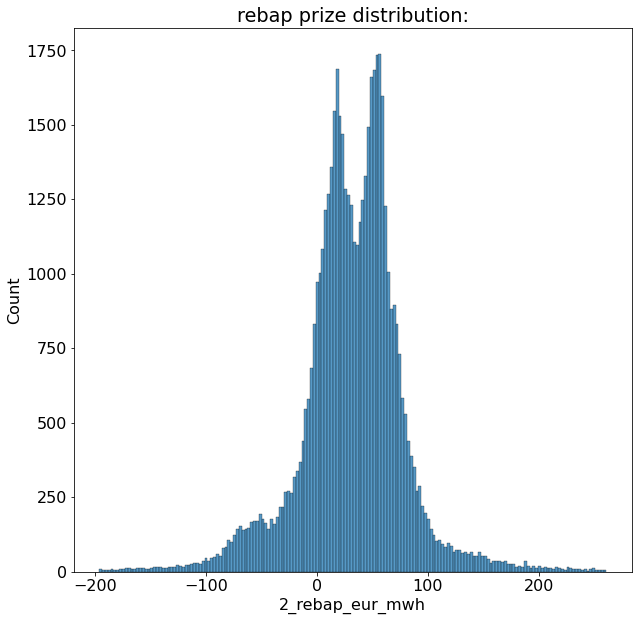

In [42]:
plt.figure(figsize=(10,10));
plt.rcParams.update({'font.size':16})
plt.title('rebap prize distribution:')
sns.histplot(data=df_pca, x="2_rebap_eur_mwh")
plt.show()

Go with a binary median classifier (above or below the Median) to categorize the rebap

### Define new column in which the rebap price_range is translated to the binary  classes 0 (below) or 1 (above zero):

In [43]:
df_pca["rebap_price_sector"] = np.nan
for i in range (len(df_pca["rebap_price_sector"])):
    if df_pca["2_rebap_eur_mwh"][i] <= 0:
        df_pca["rebap_price_sector"][i] = 0
    else:
        df_pca["rebap_price_sector"][i]= 1
"""
for j in range (len_trainset, len(df_pca["rebap_price_sector"])):
    if df_pca["2_rebap_eur_mwh"][j] <= y_median_test:
            df_pca["rebap_price_sector"][j] = 0
    else:
            df_pca["rebap_price_sector"][j]= 1
"""
df_pca["rebap_price_sector"] = df_pca["rebap_price_sector"].astype('int')

In [44]:
df_pca.head()

,1_area_1_windspeed_ms,1_area_2_windspeed_ms,1_area_4_windspeed_ms,1_area_5_windspeed_ms,1_area_6_windspeed_ms,1_area_7_windspeed_ms,1_area_8_windspeed_ms,1_area_9_windspeed_ms,1_area_10_windspeed_ms,1_area_11_windspeed_ms,...,1_area_102_windspeed_ms,1_area_103_windspeed_ms,1_area_104_windspeed_ms,1_area_105_windspeed_ms,1_area_106_windspeed_ms,1_area_107_windspeed_ms,1_area_108_windspeed_ms,1_area_109_windspeed_ms,2_rebap_eur_mwh,rebap_price_sector
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00,9.523,9.691,14.258,14.062,11.504,13.950,8.454,12.799,16.920,14.638,...,13.080,15.056,13.411,13.185,13.311,13.716,13.416,13.316,-45.66,0
2018-12-31 23:15:00,9.097,10.031,13.564,13.207,11.097,13.950,8.461,11.775,17.114,15.217,...,13.404,14.168,13.769,13.415,14.100,13.492,13.470,13.156,-139.64,0
2018-12-31 23:30:00,8.654,9.491,15.997,13.431,11.056,13.950,8.467,12.108,16.803,14.984,...,13.640,15.508,13.822,13.415,14.742,14.559,14.171,13.528,3.45,1
2018-12-31 23:45:00,8.478,9.411,16.436,13.775,11.286,14.227,8.474,12.397,16.292,15.628,...,13.640,15.806,13.822,14.343,15.156,14.916,14.171,14.125,30.48,1
2019-01-01 00:00:00,8.601,9.741,15.792,14.748,11.201,14.130,8.481,11.458,16.089,15.517,...,13.640,15.747,14.817,14.279,14.204,14.827,14.547,14.207,-66.79,0


In [45]:
df_pca["rebap_price_sector"].value_counts()

1    43736
0     9389
Name: rebap_price_sector, dtype: int64

### Train-Test_Split

In [46]:
df_pca = df_pca.drop(['2_rebap_eur_mwh'], axis= 1)

In [47]:
from sklearn.model_selection import train_test_split
X = df_pca.drop(["rebap_price_sector"],axis=1)
y = df_pca["rebap_price_sector"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print(y_train.value_counts(), y_test.value_counts())

1    34980
0     7520
Name: rebap_price_sector, dtype: int64 1    8756
0    1869
Name: rebap_price_sector, dtype: int64


### Principal Component Analysis (PCA)

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
df_scaled = pd.DataFrame(data=X_train_scaled,columns=df_pca.columns[:-1])

In [51]:
df_scaled.isna().sum()

1_area_1_windspeed_ms      0
1_area_2_windspeed_ms      0
1_area_4_windspeed_ms      0
1_area_5_windspeed_ms      0
1_area_6_windspeed_ms      0
                          ..
1_area_105_windspeed_ms    0
1_area_106_windspeed_ms    0
1_area_107_windspeed_ms    0
1_area_108_windspeed_ms    0
1_area_109_windspeed_ms    0
Length: 108, dtype: int64

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
df_scaled_pca = pca.fit(df_scaled)

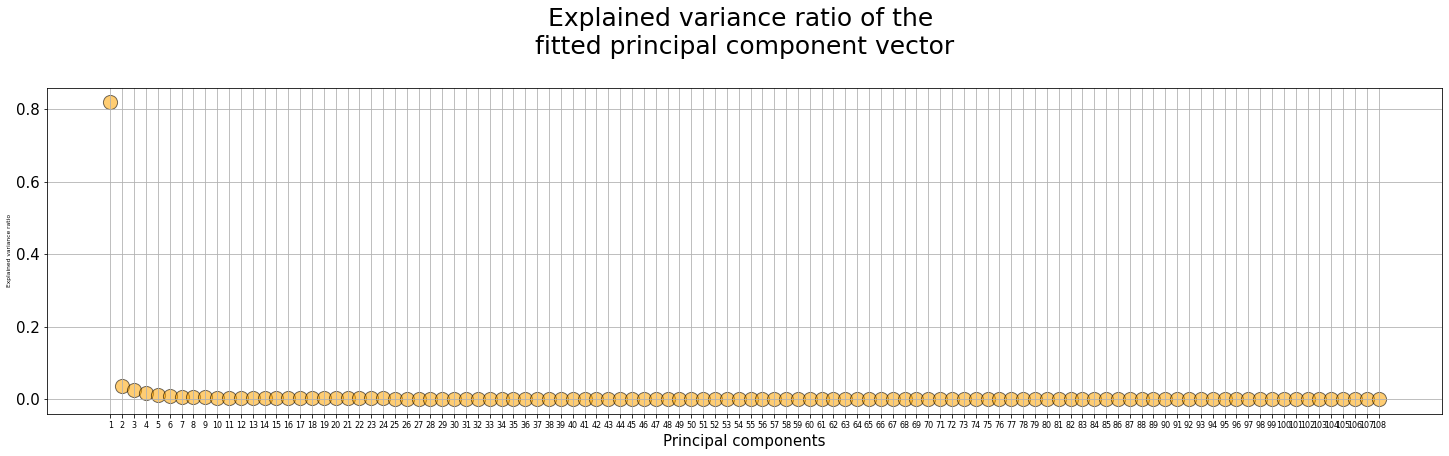

In [53]:
plt.figure(figsize=(25,6))
plt.scatter(x=[i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],
            y=df_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.55,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_scaled_pca.explained_variance_ratio_))],fontsize=8)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=6)
plt.show()

In [54]:
X_train_scaled_trans = pca.transform(df_scaled)
X_train_scaled_trans = pd.DataFrame(data=X_train_scaled_trans)
X_train_scaled_trans.head(10)

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,-7.290458,-3.943051,-1.629446,0.381091,-0.440715,0.095548,0.087962,-1.154019,-0.458465,0.718844,...,0.040058,-0.048586,0.019470,-0.033828,-0.138421,-0.010015,-0.200573,0.022855,-0.044791,0.038319
1,18.068899,-0.803088,-1.149764,-1.663092,0.169133,1.376771,1.087870,-0.079553,-0.016515,0.454235,...,-0.104115,0.121832,0.079942,0.000505,0.006963,0.081902,0.052096,0.020846,-0.052750,-0.134107
2,-6.126844,-2.657684,3.278030,-1.375860,-2.289997,-0.003547,-0.621872,0.007025,0.550961,0.391935,...,-0.045409,-0.110115,-0.088278,0.108357,0.146736,-0.013286,0.035456,-0.007273,0.000470,-0.100026
3,2.813022,-2.759640,2.200346,-0.274313,-0.254551,0.758252,-1.949081,-0.115953,0.184114,-0.116911,...,0.013316,-0.009071,-0.072133,0.104578,0.002563,-0.041809,-0.089262,-0.089538,0.013629,-0.060089
4,-5.882661,1.901147,0.516183,-0.237449,0.755694,-0.487581,0.659236,0.893598,0.402787,0.252646,...,0.054338,-0.006387,0.173446,0.014985,0.087045,0.080183,-0.105118,0.038820,0.002773,-0.003514
5,-6.046912,-3.026712,-2.772469,-2.024383,1.090939,-0.963942,-0.054465,0.245289,0.366521,-0.198181,...,-0.056197,0.008802,0.113446,0.118881,-0.119272,-0.057159,0.001022,0.010010,0.030521,0.007169
6,-8.241651,1.079016,-0.787959,1.363858,0.374353,-0.303086,0.900464,0.032561,-0.359720,-0.250492,...,0.058113,-0.099628,-0.098031,-0.033240,0.009686,-0.028493,-0.100319,-0.080367,0.061307,0.045744
7,1.619668,-4.199907,0.231374,-1.090305,-1.285964,0.165699,1.030873,-0.232198,-1.140369,0.614898,...,-0.185684,-0.267515,-0.212890,-0.141242,-0.016290,-0.134811,-0.161324,-0.166537,0.131839,-0.110317
8,-7.915375,-0.826687,-1.965973,0.984758,0.712102,-0.273294,-0.210370,-0.248077,0.070733,0.454292,...,-0.003343,-0.097982,0.036049,-0.141245,0.004468,-0.010945,0.017566,-0.033383,-0.010187,0.028052
9,-4.577602,-0.183461,-0.347437,0.891931,-1.060451,0.192294,0.390659,-0.462918,0.181706,-0.439608,...,-0.063525,0.146679,0.086522,0.026288,-0.064656,-0.094705,0.186844,-0.096574,-0.001676,0.044501


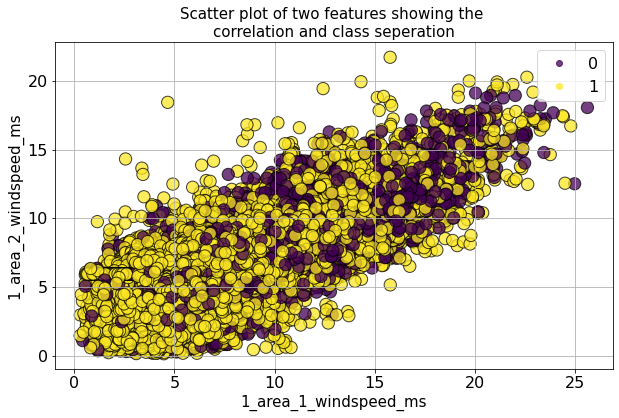

In [55]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(df_pca['1_area_12_windspeed_ms'],df_pca['1_area_22_windspeed_ms'],c=df_pca["rebap_price_sector"],edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
classes = ['0', '1']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("Scatter plot of two features showing the \ncorrelation and class seperation",fontsize=15)
plt.xlabel("1_area_1_windspeed_ms",fontsize=15)
plt.ylabel("1_area_2_windspeed_ms",fontsize=15)
plt.show()

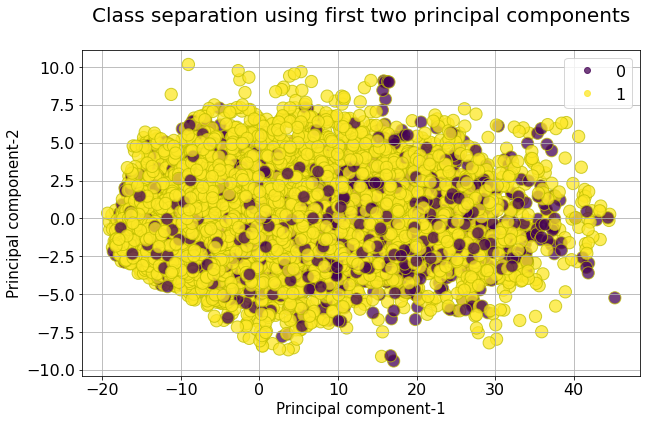

In [56]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_scaled_trans[0],X_train_scaled_trans[1],c=y_train,edgecolors='y',alpha=0.75,s=150)
classes = ['0', '1']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [57]:
from sklearn.naive_bayes import GaussianNB

In [58]:
variables = [0,1, 2, 3, 4, 5, 6]
#variables = [0, 1]

In [59]:
#TODO: instantiate the model and train it on X_train_scaled_trans with the variables defined before, y_train (data any transformations)

clf2 = GaussianNB()
clf2.fit(X_train_scaled_trans[variables], y_train)

GaussianNB()

Before we can predict on the test data, we need to transform it first. 
Remember, we used standard scaler and PCA to transform our data.

In [60]:
#TODO: use implemented standard scaler to scale data
X_test_scaled = scaler.transform(X_test)
#TODO: transform the data with implemented PCA
X_test_scaled_trans = pca.transform(X_test_scaled)

In [61]:
X_test_scaled_trans = pd.DataFrame(data=X_test_scaled_trans)

In [62]:
#TODO: predict y
y_pred = clf2.predict(X_test_scaled_trans[[0, 1, 2, 3, 4, 5, 6]])

In [63]:
# we will use the accuracy score for an easy comparison of results
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8096941176470588

              precision    recall  f1-score   support

           0       0.33      0.08      0.13      1869
           1       0.83      0.97      0.89      8756

    accuracy                           0.81     10625
   macro avg       0.58      0.52      0.51     10625
weighted avg       0.74      0.81      0.76     10625



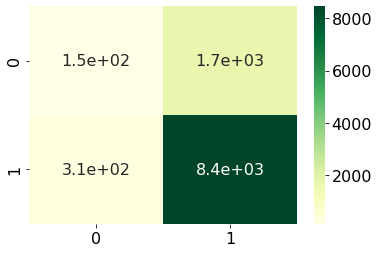

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');
print(classification_report(y_test,y_pred))

## Second Approach: More Data (columns)

To hopefully improve the accuracy of our prediction (REBAP prize above Median = "0" OR below = "1", we will now create a new datframe which additionally includes the strongest features from Dataframes 1 to 12 (see Notebook es_forecast_data_processing.ipynb for details):

In [67]:
df_5_compact = df_5[['dt_start_utc', "power_act_21", "power_act_179", "power_act_183", "power_act_202", "power_act_291", "power_act_292"]].copy()

In [69]:
df_5_compact.isna().sum()

dt_start_utc         0
power_act_21      1005
power_act_179    52754
power_act_183    52694
power_act_202    31669
power_act_291    57352
power_act_292    58004
dtype: int64

In [70]:
df_6_compact = df_6[['dt_start_utc', "power_fc_21","power_fc_176", "power_fc_179", "power_fc_183", "power_fc_202", "power_fc_206", "power_fc_222", "power_fc_291", "power_fc_292", "power_fc_325", "power_fc_327", "power_fc_339"]].copy()

In [71]:
df_10_compact = df_10[['dt_start_utc', "TTG_power_mw"]].copy()

In [72]:
df_11_compact = df_11[['dt_start_utc', "DE_power_mw", "TTG_power_mw"]].copy()

In [73]:
df_12_compact = df_12[['dt_start_utc', "50Hertz_power_mw", "DE_power_mw", "TTG_power_mw"]].copy()

In [74]:
df_pca_compact = align(df_10_compact, df_11_compact, df_12_compact, df_13, df_14)

In [75]:
df_pca_compact.head()

,1_TTG_power_mw,2_DE_power_mw,2_TTG_power_mw,3_50Hertz_power_mw,3_DE_power_mw,3_TTG_power_mw,4_area_1_windspeed_ms,4_area_2_windspeed_ms,4_area_4_windspeed_ms,4_area_5_windspeed_ms,...,4_area_101_windspeed_ms,4_area_102_windspeed_ms,4_area_103_windspeed_ms,4_area_104_windspeed_ms,4_area_105_windspeed_ms,4_area_106_windspeed_ms,4_area_107_windspeed_ms,4_area_108_windspeed_ms,4_area_109_windspeed_ms,5_rebap_eur_mwh
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00,4021.0,5042.0,4021.0,7256.0,18224.0,3117.0,9.523,9.691,14.258,14.062,...,13.405,13.080,15.056,13.411,13.185,13.311,13.716,13.416,13.316,-45.66
2018-12-31 23:15:00,0.0,5061.0,4036.0,7477.0,18652.0,3117.0,9.097,10.031,13.564,13.207,...,13.147,13.404,14.168,13.769,13.415,14.100,13.492,13.470,13.156,-139.64
2018-12-31 23:30:00,4050.0,5079.0,4050.0,7706.0,19095.0,3117.0,8.654,9.491,15.997,13.431,...,14.253,13.640,15.508,13.822,13.415,14.742,14.559,14.171,13.528,3.45
2018-12-31 23:45:00,0.0,5094.0,4061.0,7928.0,19548.0,3117.0,8.478,9.411,16.436,13.775,...,14.649,13.640,15.806,13.822,14.343,15.156,14.916,14.171,14.125,30.48
2019-01-01 00:00:00,4076.0,5112.0,4076.0,8142.0,19999.0,3117.0,8.601,9.741,15.792,14.748,...,14.324,13.640,15.747,14.817,14.279,14.204,14.827,14.547,14.207,-66.79


### Filter out those rebap prizes that are not within 3 Standard deviations of the mean:

Now we will get rid of those outliers outside the +/- 3 Standard Deviation range with the following code line:

In [76]:
std_dev = 3*df_pca_compact['5_rebap_eur_mwh'].std()
df_pca_compact = df_pca_compact[np.abs(df_pca_compact['5_rebap_eur_mwh'] - df_pca_compact['5_rebap_eur_mwh'].mean()) <= std_dev]

### Define new column in which the rebap price_range is translated to three "price_sectors":

In [77]:
y_median = df_pca_compact['5_rebap_eur_mwh'][:-4].median()
y_median

33.78

In [78]:
df_pca_compact["rebap_price_sector"] = np.nan
for i in range (len(df_pca_compact["rebap_price_sector"])):
    if df_pca_compact["5_rebap_eur_mwh"][i] <= 0:
        df_pca_compact["rebap_price_sector"][i] = 0
    else:
        df_pca_compact["rebap_price_sector"][i]= 1
df_pca_compact["rebap_price_sector"] = df_pca_compact["rebap_price_sector"].astype('int')

In [267]:
"""
df_pca_compact["rebap_price_sector"] = np.nan
for i in range (len(df_pca_compact["5_rebap_eur_mwh"])):
        if df_pca_compact["5_rebap_eur_mwh"][i] <= y_median:
            df_pca_compact["rebap_price_sector"][i] = 0
        else:
            df_pca_compact["rebap_price_sector"][i]= 1
df_pca_compact["rebap_price_sector"] = df_pca_compact["rebap_price_sector"].astype('int')
"""

In [79]:
df_pca_compact.describe()

,1_TTG_power_mw,2_DE_power_mw,2_TTG_power_mw,3_50Hertz_power_mw,3_DE_power_mw,3_TTG_power_mw,4_area_1_windspeed_ms,4_area_2_windspeed_ms,4_area_4_windspeed_ms,4_area_5_windspeed_ms,...,4_area_102_windspeed_ms,4_area_103_windspeed_ms,4_area_104_windspeed_ms,4_area_105_windspeed_ms,4_area_106_windspeed_ms,4_area_107_windspeed_ms,4_area_108_windspeed_ms,4_area_109_windspeed_ms,5_rebap_eur_mwh,rebap_price_sector
count,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,...,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000,53125.000000
mean,3160.716424,2956.664866,2456.599416,4276.531294,11305.060838,4322.445496,6.553995,6.452053,8.081869,8.755412,...,6.976944,7.374455,7.197527,6.924992,7.039588,7.140904,7.648715,7.249270,32.063320,0.823266
std,3106.288574,1780.981134,1576.576497,3491.627051,9399.891846,3013.405235,2.696233,2.591440,3.606232,3.637916,...,3.327733,3.643207,3.354086,3.435083,3.456958,3.458647,3.528072,3.493424,46.385289,0.381447
min,0.000000,29.000000,20.000000,7.000000,300.000000,97.000000,0.190000,0.848000,0.335000,0.183000,...,0.109000,0.056000,0.037000,0.221000,0.079000,0.054000,0.000000,0.019000,-196.170000,0.000000
25%,621.000000,1338.000000,980.000000,1574.000000,3233.000000,3117.000000,4.762000,4.666000,5.482000,6.204000,...,4.579000,4.785000,4.785000,4.720000,4.474000,4.664000,5.056000,4.711000,9.250000,1.000000
50%,2479.000000,2942.000000,2426.000000,3284.000000,8448.000000,3117.000000,6.352000,6.195000,7.580000,8.592000,...,6.439000,6.639000,6.755000,6.325000,6.528000,6.636000,7.154000,6.719000,33.780000,1.000000
75%,4531.000000,4511.000000,3838.000000,5925.000000,16288.000000,4720.000000,8.273000,7.908000,10.305000,10.843000,...,8.941000,9.432000,9.149000,8.639000,9.053000,9.120000,9.927000,9.440000,57.580000,1.000000
max,16233.000000,6574.000000,5617.000000,20336.000000,43628.000000,16233.000000,19.417000,19.846000,27.414000,26.606000,...,25.011000,27.357000,24.993000,24.149000,25.414000,26.118000,27.436000,25.819000,261.100000,1.000000


In [80]:
df_pca_compact.isna().sum()

1_TTG_power_mw             0
2_DE_power_mw              0
2_TTG_power_mw             0
3_50Hertz_power_mw         0
3_DE_power_mw              0
                          ..
4_area_107_windspeed_ms    0
4_area_108_windspeed_ms    0
4_area_109_windspeed_ms    0
5_rebap_eur_mwh            0
rebap_price_sector         0
Length: 116, dtype: int64

In [81]:
df_pca_compact["rebap_price_sector"].value_counts()

1    43736
0     9389
Name: rebap_price_sector, dtype: int64

In [82]:
plus_perc = 43736/(9389 + 43736)
print(plus_perc)

0.8232658823529412


In [83]:
df_pca_compact.drop("5_rebap_eur_mwh", axis=1)

,1_TTG_power_mw,2_DE_power_mw,2_TTG_power_mw,3_50Hertz_power_mw,3_DE_power_mw,3_TTG_power_mw,4_area_1_windspeed_ms,4_area_2_windspeed_ms,4_area_4_windspeed_ms,4_area_5_windspeed_ms,...,4_area_101_windspeed_ms,4_area_102_windspeed_ms,4_area_103_windspeed_ms,4_area_104_windspeed_ms,4_area_105_windspeed_ms,4_area_106_windspeed_ms,4_area_107_windspeed_ms,4_area_108_windspeed_ms,4_area_109_windspeed_ms,rebap_price_sector
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:00:00,4021.0,5042.0,4021.0,7256.0,18224.0,3117.0,9.523,9.691,14.258,14.062,...,13.405,13.080,15.056,13.411,13.185,13.311,13.716,13.416,13.316,0
2018-12-31 23:15:00,0.0,5061.0,4036.0,7477.0,18652.0,3117.0,9.097,10.031,13.564,13.207,...,13.147,13.404,14.168,13.769,13.415,14.100,13.492,13.470,13.156,0
2018-12-31 23:30:00,4050.0,5079.0,4050.0,7706.0,19095.0,3117.0,8.654,9.491,15.997,13.431,...,14.253,13.640,15.508,13.822,13.415,14.742,14.559,14.171,13.528,1
2018-12-31 23:45:00,0.0,5094.0,4061.0,7928.0,19548.0,3117.0,8.478,9.411,16.436,13.775,...,14.649,13.640,15.806,13.822,14.343,15.156,14.916,14.171,14.125,1
2019-01-01 00:00:00,4076.0,5112.0,4076.0,8142.0,19999.0,3117.0,8.601,9.741,15.792,14.748,...,14.324,13.640,15.747,14.817,14.279,14.204,14.827,14.547,14.207,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-12 08:15:00,8712.0,1233.0,626.0,1029.0,2660.0,1333.0,2.998,2.573,7.265,8.285,...,5.717,6.387,6.349,6.721,6.420,6.719,6.754,6.960,6.915,1
2020-07-12 08:30:00,1352.0,1219.0,614.0,1090.0,2739.0,1352.0,2.896,2.643,7.255,8.143,...,5.571,6.275,6.043,6.771,6.544,6.389,6.576,6.607,6.651,1
2020-07-12 08:45:00,600.0,1204.0,600.0,1148.0,2817.0,1371.0,3.106,2.383,7.521,8.318,...,5.413,6.225,5.080,6.540,5.893,5.834,6.700,6.222,6.344,1


### Train-Test_Split

In [84]:
from sklearn.model_selection import train_test_split
X_2 = df_pca_compact.drop(["rebap_price_sector"],axis=1)
y_2 = df_pca_compact["rebap_price_sector"]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

### Principal Component Analysis (PCA)

In [85]:
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
df_scaled_2 = pd.DataFrame(data=X_train_scaled_2,columns=df_pca_compact.columns[:-1])

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
df_scaled_pca_2 = pca.fit(df_scaled_2)

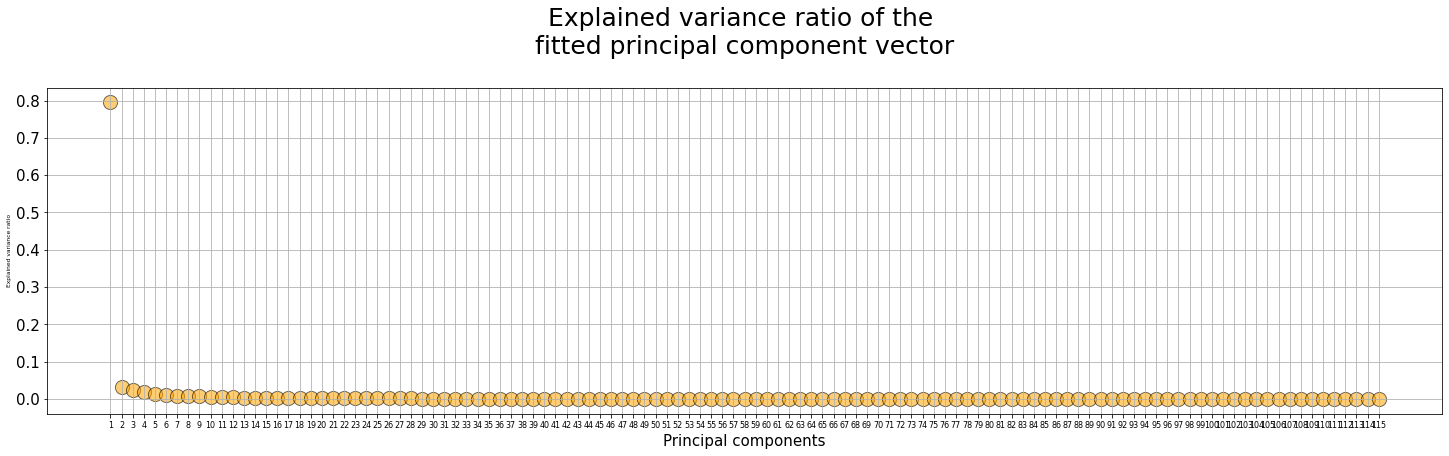

In [87]:
plt.figure(figsize=(25,6))
plt.scatter(x=[i+1 for i in range(len(df_scaled_pca_2.explained_variance_ratio_))],
            y=df_scaled_pca_2.explained_variance_ratio_,
            s=200, alpha=0.55,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_scaled_pca_2.explained_variance_ratio_))],fontsize=8)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=6)
plt.show()

In [88]:
X_train_scaled_trans_2 = pca.transform(df_scaled_2)
X_train_scaled_trans_2 = pd.DataFrame(data=X_train_scaled_trans_2)
X_train_scaled_trans_2.head(10)

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,-7.451735,-4.007197,-1.630737,-0.294841,-0.170259,0.356860,-0.468634,-0.364939,-0.334020,1.256468,...,-0.058038,0.021677,-0.045525,-0.135313,-0.016164,-0.205012,0.010346,-0.043353,0.021108,-0.037816
1,18.040410,-0.688192,-1.522807,2.345154,-0.650436,0.169274,0.059299,1.595325,0.830434,1.588943,...,0.143543,0.094158,-0.028869,0.006809,0.069280,0.045890,0.020130,-0.061022,0.044114,0.140586
2,-6.134711,-2.591963,3.415843,1.128737,1.727554,1.511696,0.277243,-0.877471,-0.913268,0.091052,...,-0.094292,-0.091012,0.124522,0.138983,-0.010933,0.029749,-0.011491,-0.006384,0.069412,0.085248
3,3.273508,-2.833306,2.533952,-0.545526,1.985678,-1.005327,-1.102315,-0.196703,-0.445311,-0.702059,...,-0.016884,-0.079693,0.127032,-0.012765,-0.057489,-0.077904,-0.069982,0.017525,-0.096918,0.071224
4,-6.145930,2.073682,0.507656,0.640231,-1.261184,0.332600,0.722606,0.459879,-0.176570,-0.852802,...,-0.023336,0.171222,0.019154,0.081471,0.072548,-0.115905,0.023199,0.000926,0.055982,-0.001946
5,-6.360721,-2.998299,-2.920275,2.334259,-0.685709,-0.382048,0.870049,-0.364905,-0.081868,-0.948216,...,-0.004524,0.122608,0.112153,-0.124878,-0.066124,-0.005882,-0.005707,0.024014,0.074093,-0.018748
6,-8.316482,0.983423,-0.909200,-1.189597,-0.586852,-0.458407,-0.390947,-0.332547,0.479792,0.844617,...,-0.093708,-0.094767,-0.017146,0.015228,-0.023997,-0.105288,-0.066157,0.068705,0.019267,-0.054306
7,1.834883,-4.238631,0.230370,1.104007,1.081991,0.916985,-1.691344,0.475399,1.733066,1.478364,...,-0.274155,-0.220525,-0.118460,0.009033,-0.115982,-0.158309,-0.141953,0.154162,-0.008446,0.111337
8,-7.848902,-0.916508,-1.748098,-1.273308,0.133900,-0.716510,-0.435773,0.186646,0.286644,-0.655319,...,-0.109043,0.032462,-0.129493,0.004656,-0.016556,0.005742,-0.057416,-0.012501,0.094833,-0.044768
9,-4.696574,-0.201852,-0.300453,-0.845143,0.105741,0.990124,-0.125291,0.069795,0.172054,0.774795,...,0.150235,0.093550,0.017885,-0.062604,-0.090292,0.194958,-0.097540,0.004033,-0.033404,-0.043224


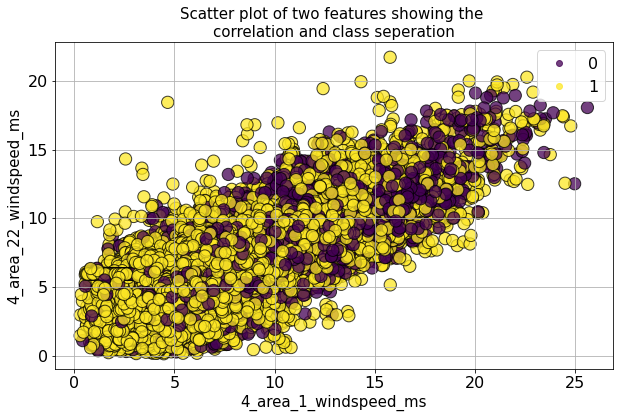

In [89]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(df_pca_compact['4_area_12_windspeed_ms'],df_pca_compact['4_area_22_windspeed_ms'],c=df_pca_compact["rebap_price_sector"],edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
classes = ['0', '1']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title("Scatter plot of two features showing the \ncorrelation and class seperation",fontsize=15)
plt.xlabel("4_area_1_windspeed_ms",fontsize=15)
plt.ylabel("4_area_22_windspeed_ms",fontsize=15)
plt.show()

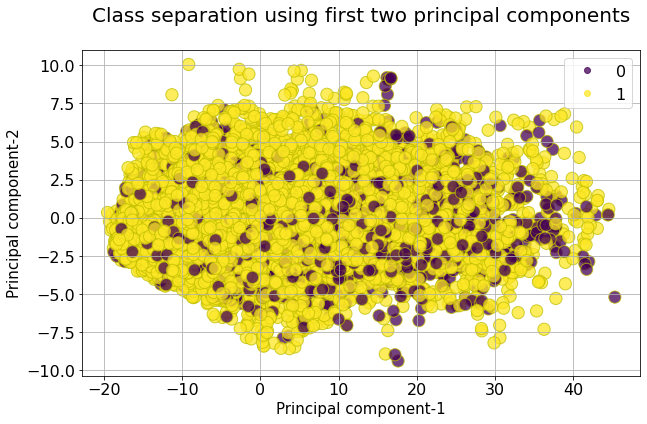

In [90]:
plt.figure(figsize=(10,6))
plt.scatter(X_train_scaled_trans_2[0],X_train_scaled_trans_2[1],c=y_train_2,edgecolors='y',alpha=0.75,s=150)
classes = ['0', '1']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [91]:
from sklearn.naive_bayes import GaussianNB
# variables = [0, 1, 2, 3, 4, 5, 6]
variables = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#TODO: instantiate the model and train it on X_train_scaled_trans with the variables defined before, y_train (data any transformations)

clf2 = GaussianNB()
clf2.fit(X_train_scaled_trans_2[variables], y_train_2)

GaussianNB()

In [92]:
#TODO: use implemented standard scaler to scale data
X_test_scaled_2 = scaler.transform(X_test_2)
#TODO: transform the data with implemented PCA
X_test_scaled_trans_2 = pca.transform(X_test_scaled_2)

X_test_scaled_trans_2 = pd.DataFrame(data=X_test_scaled_trans_2)

#TODO: predict y
y_pred = clf2.predict(X_test_scaled_trans_2[[0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [93]:
# we will use the accuracy score for an easy comparison of results
from sklearn.metrics import accuracy_score
accuracy_score(y_test_2, y_pred)

0.9102117647058824

              precision    recall  f1-score   support

           0       0.90      0.55      0.68      1869
           1       0.91      0.99      0.95      8756

    accuracy                           0.91     10625
   macro avg       0.91      0.77      0.81     10625
weighted avg       0.91      0.91      0.90     10625



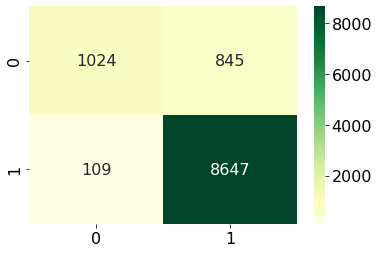

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

sns.heatmap(confusion_matrix(y_test, y_pred), fmt= ".0f", annot=True, cmap='YlGn');
print(classification_report(y_test,y_pred))

In [400]:
1024/(1012+857)

0.5478865703584804